# Проект по Методи и софтуер за машинно обучение
Студент: Кристиян Кръчмаров <br>
Фак. номер: 791324005 <br>


## Зареждане на данните

In [1]:
import pandas as pd

path = "../Data/"
data = pd.read_csv(path + "shuffle_email_spam_classification.csv")
data.info()
print("\nNaN in data: {}".format(data.isna().any().any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB

NaN in data: False


In [2]:
data = data.iloc[:, 1:]  # remove 'Email No' column

X = data.iloc[:, :-1]  # explanatory variables
Y = data.iloc[:, -1]  # result

print(X.shape)
print(Y.shape)

(5172, 3000)
(5172,)


## Helpers
Няколко helper метода <br>

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

def get_metrics(classifier, x_train, y_train, x_test, y_test):
    """Train a classifier and get different metrics"""

    classifier.fit(x_train, y_train)  # train

    predicted = classifier.predict(x_test)  # get prediction
    probabilities = classifier.predict_proba(x_test)  # get probabilities of each class
    probabilities = probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probabilities)  # ROC curve
    auc = roc_auc_score(y_test, probabilities)  # AUC score

    conf_matrix = confusion_matrix(y_test, predicted)  # confusion matrix

    accuracy = classification_report(y_test, predicted, output_dict=True)['accuracy']  # accuracy
    cl_report = classification_report(y_test, predicted, output_dict=False)  # classification report

    return {
        "ACC": accuracy,
        "AUC": auc,
        "TPR": tpr,
        "FPR": fpr,
        "Threshold": threshold,
        "ConfusionMatrix": conf_matrix,
        "ClassificationReport": cl_report,
    }

In [4]:
import matplotlib.pyplot as plt

def get_metrics_train_and_test(classifier, x_train, y_train, x_test, y_test, plot_roc_curve=False):
    """
    Get metrics for a classifier when training and test data are the same and also train and test data are different.
    Plot the ROC curve.
    Return the metrics for each training scenario
    """
    train_train = get_metrics(classifier, x_train, y_train, x_train, y_train)
    train_test = get_metrics(classifier, x_train, y_train, x_test, y_test)

    # Plot setup
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].set_title("ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].set_title("ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

        axes[0].plot(train_test["FPR"], train_test["TPR"], marker="", color="green", alpha=0.6)
        axes[1].plot(train_train["FPR"], train_train["TPR"], marker="", color="red", alpha=0.6)

        plt.show()

    return {
        "train-train": train_train,
        "train-test": train_test,
    }

За метода `k_fold_cross_validation` използваме `KFold` който разделя данните

In [5]:
from sklearn.model_selection import KFold

def k_fold_cross_validation_classifier(classifier, X: pd.DataFrame, Y: pd.DataFrame, splits=10, plot_roc_curve=False):
    """
    Perform k-fold cross validation for classifier.
    Plot the ROC curve for each fold.
    Return performance metrics for each fold.
    """

    kf = KFold(n_splits=splits, shuffle=True)

    df_columns = ["Fold", "ACC Test", "ACC Training", "ACC ratio", "AUC Test", "AUC Training", "AUC ratio", "CONF_MTX"]
    performance_df = pd.DataFrame(columns=df_columns)

    # plot setup
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].title.set_text("k-Fold ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].title.set_text("k-Fold ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

    i = 0
    #k-fold
    for trainIndex, testIndex in kf.split(X, Y):
        print(f"Processing fold {i + 1}...")
        X_train, X_test = X.iloc[trainIndex], X.iloc[testIndex]
        Y_train, Y_test = Y.iloc[trainIndex], Y.iloc[testIndex]

        metrics_train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
        metrics_train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

        if plot_roc_curve:
            axes[0].plot(metrics_train_test["FPR"], metrics_train_test["TPR"], marker="", color="blue", alpha=0.6)
            axes[1].plot(metrics_train_train["FPR"], metrics_train_train["TPR"], marker="", color="orange", alpha=0.6)

        temp = {'Fold': i,
                'ACC Test': metrics_train_test["ACC"],
                'ACC Training': metrics_train_train["ACC"],
                'ACC ratio': metrics_train_test["ACC"] / metrics_train_train["ACC"],
                'AUC Test': metrics_train_test["AUC"],
                'AUC Training': metrics_train_train["AUC"],
                'AUC ratio': metrics_train_test["AUC"] / metrics_train_train["AUC"],
                'CONF_MTX': metrics_train_test["ConfusionMatrix"]}

        temp_df = pd.DataFrame([temp])
        performance_df = pd.concat([performance_df, temp_df], ignore_index=True)
        i = i + 1

    if plot_roc_curve:
        plt.show()

    return performance_df

In [6]:
def print_metrics(metrics_train_and_test):
    """Print metrics for differently trained classifier"""
    train_train = metrics_train_and_test.get('train-train', 'not-found')
    train_test = metrics_train_and_test.get('train-test', 'not-found')

    print("Train-Train ACC: {}".format(train_train.get('ACC', 'not-found')))
    print("Train-Test ACC: {}".format(train_test.get('ACC', 'not-found')))
    print("\n")
    print("Train-Train AUC: {}".format(train_train.get('AUC', 'not-found')))
    print("Train-Test AUC: {}".format(train_test.get('AUC', 'not-found')))
    print("\n")
    print("Train-Train Confusion Matrix: \n {}".format(train_train.get('ConfusionMatrix', 'not-found')))
    print("\n")
    print("Train-Test Confusion Matrix: \n {}".format(train_test.get('ConfusionMatrix', 'not-found')))
    print("\n")
    # print("Train-Train Classification report: \n {}".format(train_train.get('ClassificationReport', 'not-found')))
    # print("\n")
    # print("Train-Test Classification report: \n {}".format(train_test.get('ClassificationReport', 'not-found')))

In [7]:
def plot_history_nn(nn):
    """Plots graphs for accuracy and loss for the duration of the training of the Neural Network"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(nn.history['accuracy'], color='blue')
    ax[0].plot(nn.history['val_accuracy'], color='green')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Validate'])
    ax[0].axis(ymin=0.5, ymax=1.1)
    ax[0].margins(0.03)

    ax[1].plot(nn.history['loss'], color='blue')
    ax[1].plot(nn.history['val_loss'], color='red')
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Validate'])
    ax[1].margins(0.03)

    plt.show()

## 1. Logistic regression
Първо ще обуча един класификатор `LogisticRegression` без preprocessing <br>
Използвам `random_state`, за да може данните които се използват за обучаване и тест да са едни и същи и само промяната на модела да влияе на резултатите.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


D:\Python venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Python venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

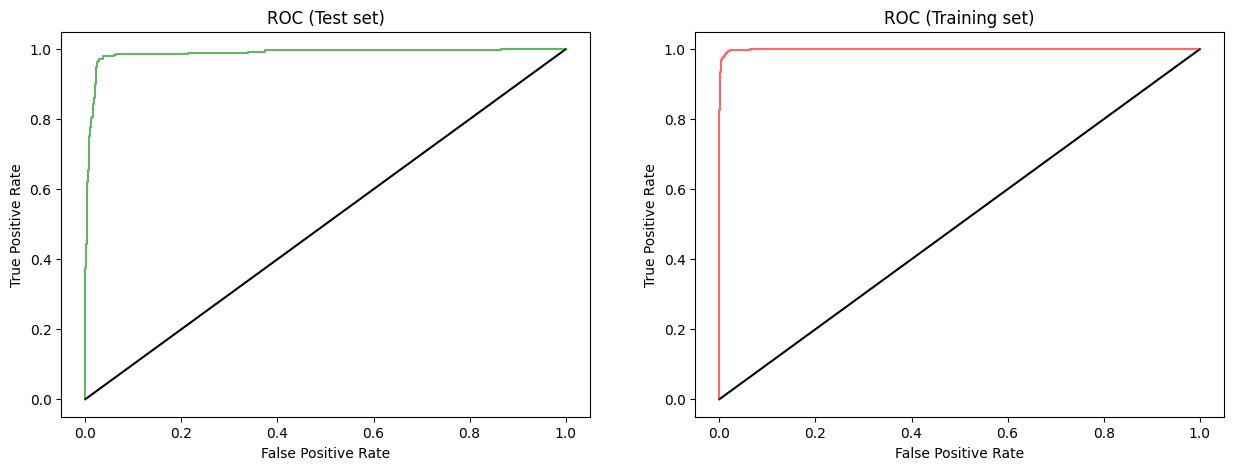

In [9]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Проверяваме модела чрез k_fold cross валидация

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


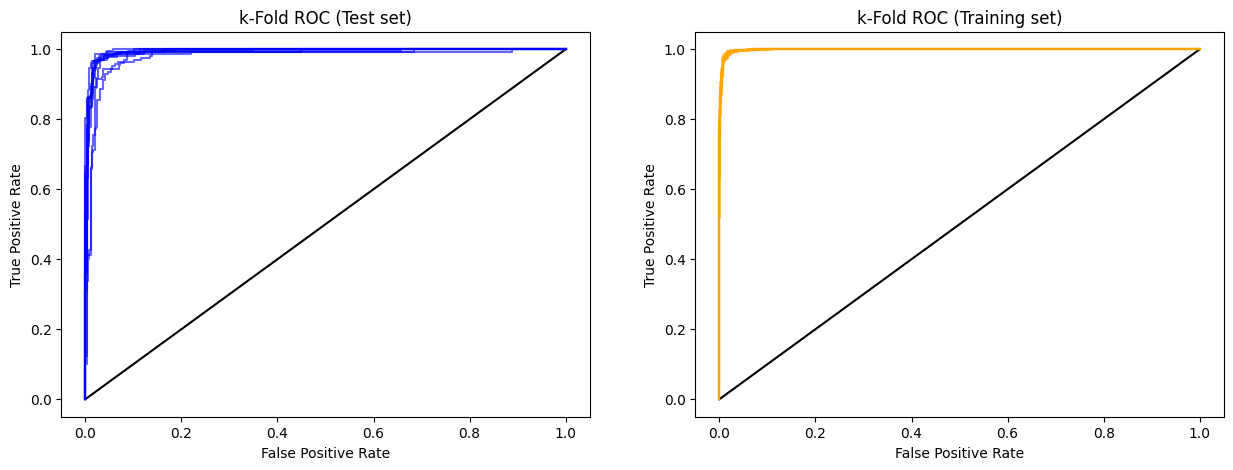

In [10]:
import warnings  # to not log the same warning on every iteration

warnings.filterwarnings('ignore')
lr_k_fold = k_fold_cross_validation_classifier(logistic_regression, X, Y, plot_roc_curve=True)
warnings.filterwarnings('default')

In [11]:
print_metrics(lr_metrics_train_and_test)

Train-Train ACC: 0.9869470630891951
Train-Test ACC: 0.9710144927536232


Train-Train AUC: 0.9993217856604816
Train-Test AUC: 0.9876248034231796


Train-Train Confusion Matrix: 
 [[2898   35]
 [  19 1185]]


Train-Test Confusion Matrix: 
 [[719  20]
 [ 10 286]]




Сега ще приложа някакъв вид preprocessing, за да се види дали ще има промяна <br>
В случая съм използвал `MinMaxScaler` чрез който всичките ни данни ще са в диапазона $[0,1]$.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


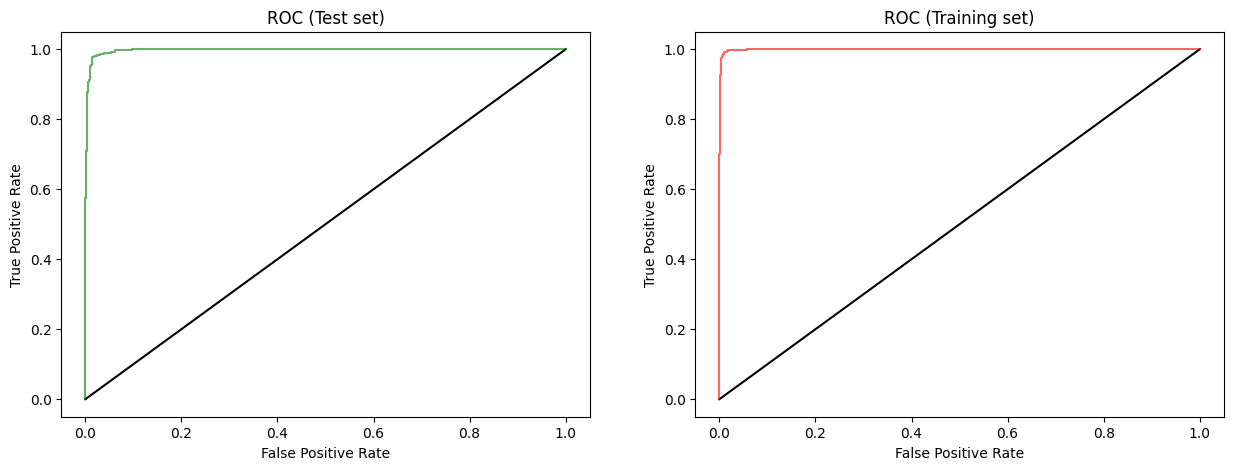

In [13]:
logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Processing fold 1...


C:\Users\krist\AppData\Local\Temp\ipykernel_31924\2993316972.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


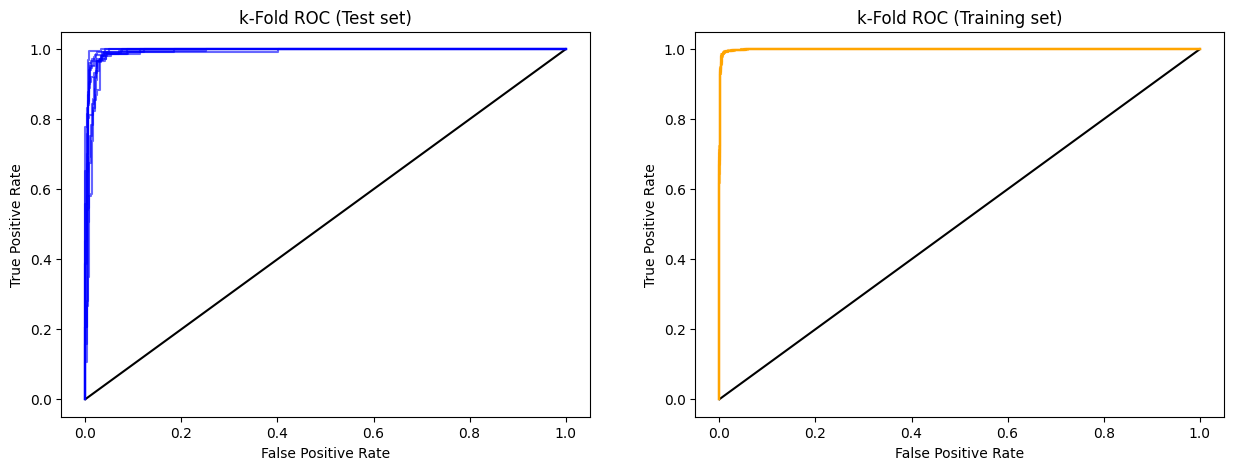

In [14]:
lr_k_fold = k_fold_cross_validation_classifier(logistic_regression, X_scaled, Y, plot_roc_curve=True)

In [15]:
print_metrics(lr_metrics_train_and_test)

Train-Train ACC: 0.9886391104665216
Train-Test ACC: 0.9835748792270531


Train-Train AUC: 0.9992679816001441
Train-Test AUC: 0.9973119262699778


Train-Train Confusion Matrix: 
 [[2922   11]
 [  36 1168]]


Train-Test Confusion Matrix: 
 [[729  10]
 [  7 289]]




Точността $ACC$ се повиши до Train-Test $ACC \approx 0.98$, което е подобрение. <br>
Не се наблюдава underfitting или overfitting

## 2. Random forest
Ще обучим един `RandomForestClassifier` без preprocessing на данните за да видим как ще се справи

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


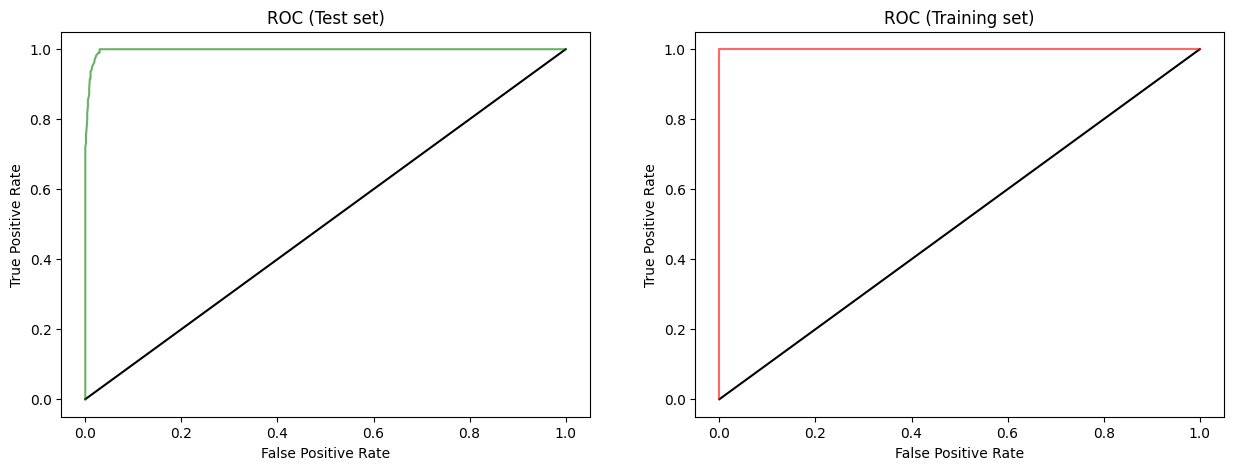

In [17]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

Processing fold 1...


C:\Users\krist\AppData\Local\Temp\ipykernel_31924\2993316972.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


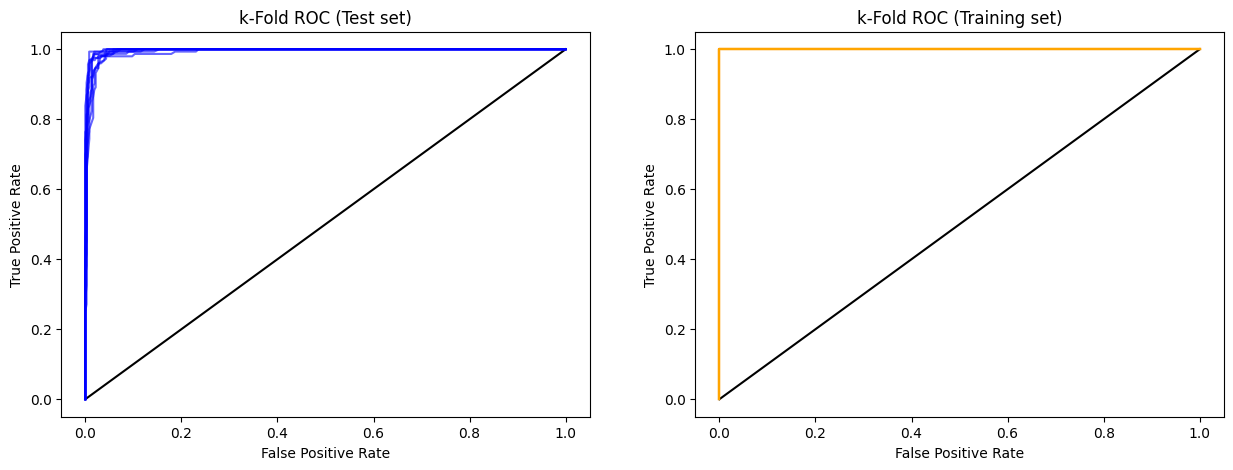

In [18]:
rf_k_fold = k_fold_cross_validation_classifier(random_forest, X, Y, plot_roc_curve=True)

In [19]:
print_metrics(rf_metrics_train_and_test)

Train-Train ACC: 1.0
Train-Test ACC: 0.9758454106280193


Train-Train AUC: 1.0
Train-Test AUC: 0.9975793621767911


Train-Train Confusion Matrix: 
 [[2933    0]
 [   0 1204]]


Train-Test Confusion Matrix: 
 [[728  11]
 [ 14 282]]




Модела се справя добре с данните на които е обучен, както и тестовите данни. <br>
Да видим дали с някакъв вид preprocessing ще има промяна. За целта ще използвам отново `MinMaxScaller`.

In [20]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


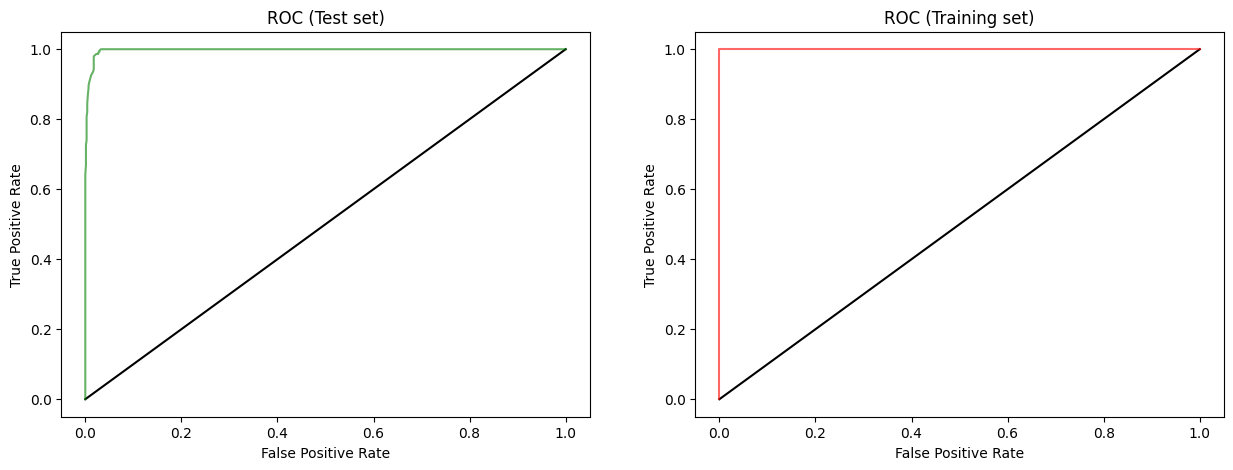

In [21]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

Processing fold 1...


C:\Users\krist\AppData\Local\Temp\ipykernel_31924\2993316972.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


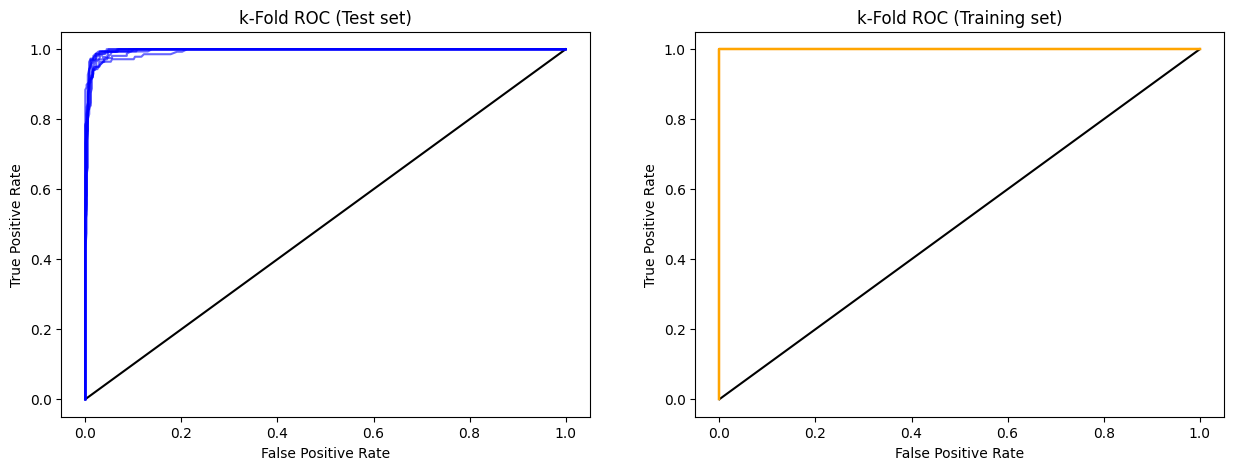

In [22]:
rf_k_fold = k_fold_cross_validation_classifier(random_forest, X_scaled, Y, plot_roc_curve=True)

In [23]:
print_metrics(rf_metrics_train_and_test)

Train-Train ACC: 1.0
Train-Test ACC: 0.978743961352657


Train-Train AUC: 1.0
Train-Test AUC: 0.9975542186299967


Train-Train Confusion Matrix: 
 [[2933    0]
 [   0 1204]]


Train-Test Confusion Matrix: 
 [[726  13]
 [  9 287]]




Има пренебрежително подобрение за точността: от $ACC = 0.975$ на $ACC = 0.978$. <br>
Следователно preprocessing не е необходим. <br>
Няма наличиние на underfiting или overfitting.

## 3. Neural network
Ще се наложи използването на `MinMaxScaller`, тъй като невронните мрежи са чуствителни към мащаба на данните

In [24]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


За първата мрежа ще използваме следната структура за слоевете:
1. 32 неврона с активационна функция relu
2. 16 неврона с активационна функция relu
3. 1 резултатен с активационна функция sigmoid

Модела който ще използвам е `Sequential`. <br>
С `layers.Input` се задават броя на началните параметри. <br>
За `optimizer` ще използваме `adam`, a за `loss` - `binary_crossentropy`

In [25]:
from keras import models, layers

NUMBER_INPUTS = X_train.shape[1]
print(NUMBER_INPUTS)

network_layers = [
    layers.Input(shape=(NUMBER_INPUTS,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
]

neural_network = models.Sequential(network_layers)

neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network.summary()

3000


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        96,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,577 (377.25 KB)

 Trainable params: 96,577 (377.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = neural_network.fit(X_train, Y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7207 - loss: 0.6192 - val_accuracy: 0.8961 - val_loss: 0.3702
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9363 - loss: 0.2939 - val_accuracy: 0.9734 - val_loss: 0.1809
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.1372 - val_accuracy: 0.9783 - val_loss: 0.1198
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0776 - val_accuracy: 0.9855 - val_loss: 0.0884
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0584 - val_accuracy: 0.9831 - val_loss: 0.0704
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0360 - val_accuracy: 0.9831 - val_loss: 0.0692
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0283 - val_accuracy: 0.9831 - val_loss: 0.0632
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0224 - val_accuracy: 0.9831 - val_loss:

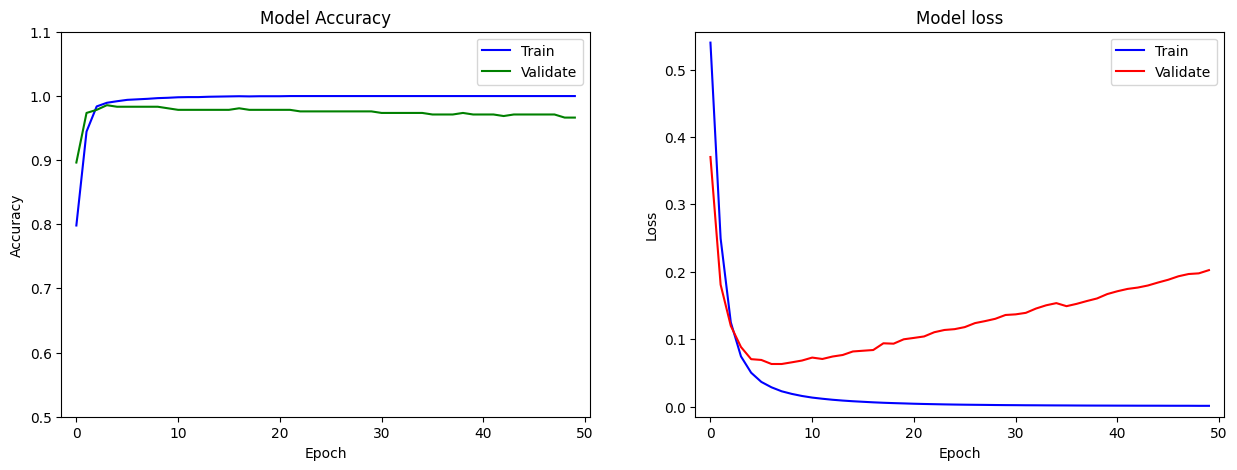

In [27]:
plot_history_nn(history)

Невронната мрежа започва да overfit-ва oколо 5тата епоха, защото loss функцията за валидационнитте данни започва да расте. <br>
Точността на валидационните данни спира да се увеличава и започва леко да намалява. <br>
Като опит за подобрение на резултата ще добавя още eдин слой и ще намаля броя епохи

In [28]:
from keras import regularizers

network_layers2 = [
    layers.Input(shape=(NUMBER_INPUTS,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
]

neural_network2 = models.Sequential(network_layers2)
neural_network2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │       192,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,689 (760.50 KB)

 Trainable params: 194,689 (760.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history2 = neural_network2.fit(X_train, Y_train, epochs=30, batch_size=64, validation_split=0.1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7472 - loss: 0.5286 - val_accuracy: 0.9300 - val_loss: 0.1838
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.1276 - val_accuracy: 0.9831 - val_loss: 0.0739
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0463 - val_accuracy: 0.9855 - val_loss: 0.0698
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0243 - val_accuracy: 0.9831 - val_loss: 0.0610
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0153 - val_accuracy: 0.9831 - val_loss: 0.0511
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0116 - val_accuracy: 0.9831 - val_loss: 0.0691
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accuracy: 0.9807 - val_loss: 0.0643
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0073 - val_accuracy: 0.9807 - val_loss:

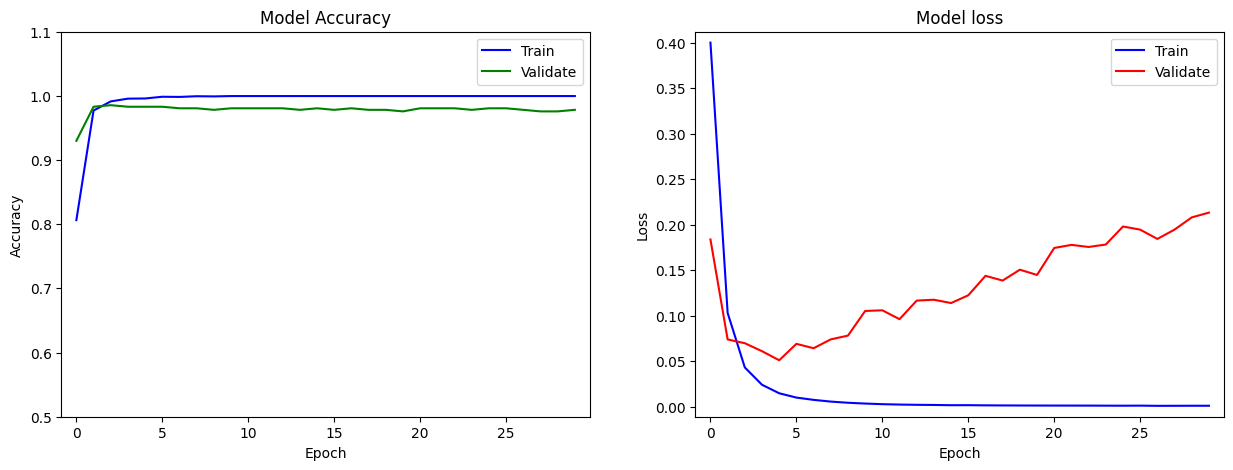

In [30]:
plot_history_nn(history2)

Отново има наличие на overfitting, защото loss функцията за валидационните данни расте и е по голяма от тази за обучителните данни. <br>
Точността на валидационните данни започва да намалява много леко <br>
За решение този проблем ще добавя регуляризация под формата на `kernel_regularizer` като в случая ще бъде L2. <br>
Също така ще добавя няколко `Dropout` слоя които ще изключват част от невроните по време на обучение.


In [31]:
network_layers3 = [
    layers.Input(shape=(NUMBER_INPUTS,)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
]

neural_network3 = models.Sequential(network_layers3)

neural_network3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │       192,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,689 (760.50 KB)

 Trainable params: 194,689 (760.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history3 = neural_network3.fit(X_train, Y_train, epochs=30, batch_size=64, validation_split=0.1)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7038 - loss: 1.8202 - val_accuracy: 0.7126 - val_loss: 0.8727
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.7987 - val_accuracy: 0.9034 - val_loss: 0.5993
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9233 - loss: 0.5653 - val_accuracy: 0.9227 - val_loss: 0.4722
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.4624 - val_accuracy: 0.9589 - val_loss: 0.4071
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9583 - loss: 0.4057 - val_accuracy: 0.9541 - val_loss: 0.3727
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9522 - loss: 0.3782 - val_accuracy: 0.9686 - val_loss: 0.3694
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.3491 - val_accuracy: 0.9734 - val_loss: 0.3337
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9627 - loss: 0.3384 - val_accuracy: 0.9324 - val_loss:

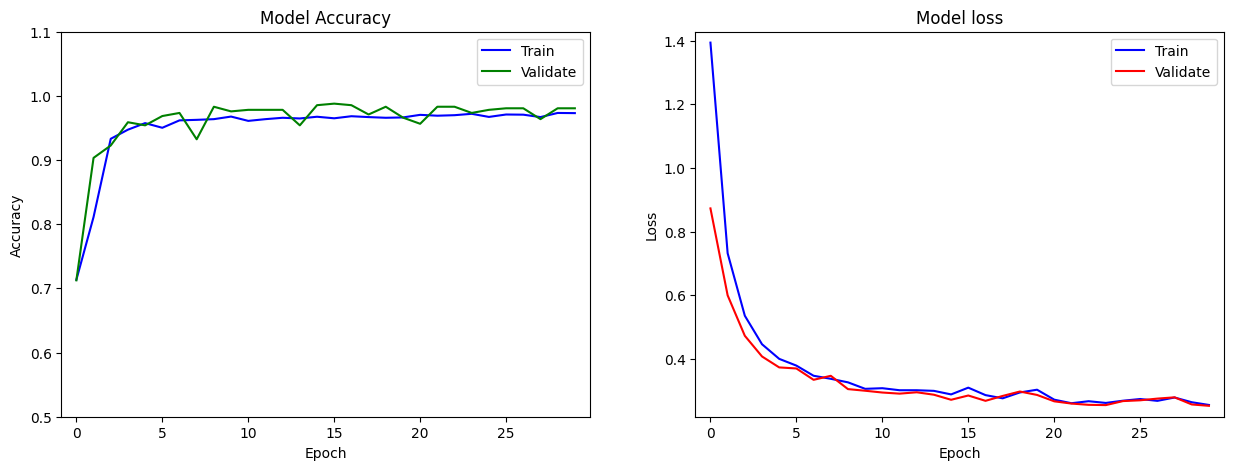

In [33]:
plot_history_nn(history3)

Тук моделът изглежда да е балансиран. <br>
Графиките на точността са близки една до друга и е с високи стойности. За загубата имаме близки графики и стойностите намаляват.